In [1]:
# display all output and eliminate scrolling in output areas

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

<h2>Discovering Disease Outbreaks from News Headlings - Part 3</h2>

<em>Objective</em>

Cluster (find groups of) headlines based on the geographic coordinates using both k-means clustering and DBSCAN. Visualize the clusters on a world map to check the results. Try different parameters and distance measures in the algorithms to produce better clusters.

<em>Initial Setup</em>

As first steps will simply import the numpy and pandas libraries and, subsequently, load the 'headlines' dataframe stored at the end of Part 2.

In [3]:
# Initial Libraries
import numpy as np
import pandas as pd

# Reading the dataframe produced at the end of Part 2 with columns
# containing the headline (text), city, country, latitude, longitude, and countrycode
df = pd.read_csv('data\df_headlines_complete_info_p2.txt', sep='|')
df.info()
df.describe(include=object)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611 entries, 0 to 610
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Headline     611 non-null    object 
 1   City         611 non-null    object 
 2   Country      15 non-null     object 
 3   Latitude     611 non-null    float64
 4   Longitude    611 non-null    float64
 5   CountryCode  611 non-null    object 
dtypes: float64(2), object(4)
memory usage: 28.8+ KB


,Headline,City,Country,CountryCode
count,611,611,15,611
unique,608,577,10,94
top,Barcelona Struck by Spanish Flu,Madrid,Brazil,US
freq,2,4,3,303


<h3>1. Apply k-means clustering and the DBSCAN algorithm to the latitude and longitude of each headline.</h3>
<ul>
    <li>Use the default initial parameters for the algorithm or, if you have prior experience, choose parameters you think will work well.</li>
    <li>Assign the cluster labels as another column on the DataFrame.</li>
</ul>

<h4>Clustering</h4>

Unlike classification where the classes of objects in the training data are known ahead of time, clustering is a type of unsupervised learning where the objects are 'unlabeled'. "In cluster analysis or clustering the task is to group a set of objects in such a way that objects in the same group (called a cluster) are more similar (in some sense) to each other than to those in other groups (clusters)." 

Cluster analysis itself is not one specific algorithm. Instead, it is a collection algorithms that differ significantly in their understanding of what constitutes a cluster and how to efficiently find them. Two of the better known algorithms are K-Means and DBScan. 

K-Means is a form of 'centroid-based' clustering, while DBScan is a form of 'density-based clustering. Both of these algorithms (as well as 8 others) are supported by the 'sklearn.cluster' module in the Python machine learning library called 'scikit-learn'. Each clustering algorithm in the module defines a class along with it's associated parameters and methods. For K-Means the class is 'sklearn.cluster.KMeans' and for DBScan the class is 'sklearn.cluster.DBSCAN'.

<h5>1.1.a. Using K_Means to Cluster Headlines based on Latitude and Longitude</h5>

In [4]:
from sklearn.cluster import KMeans

# standard matrix of [n_samples,m_features]
coordinates = df[['Latitude', 'Longitude']].values 

# KMeans using default parameters
kmeans = KMeans()
kmeans.fit(coordinates)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In this case the default settings were used for the KMeans parameters. Key among these are: 
<ol>
    <li><em>n_clusters</em> -- the number of clusters  to be generated</li>
    <li><em>init</em> --the method  used to seed the cluster centers cluster</li>
    <li><em>n_init</em> -- the number  of times that the seeding process will be run in order to determine the set of centers that minimizes the 'within-cluster sum-of-squares' (i.e., 'inertia')</li>
</ol>    
In this case the key values were n_clusters=8, init='k-means++', and n_int=10. 

<h5>1.1.b. Using K_Means to add Cluster Labels to headlines dataframe 'df'</h5>

In [5]:
df['KMClusters'] = kmeans.fit_predict(coordinates)

print('List of df Columns after addition of KMClusters:\n')
print(df.columns)

print('\nFrequency Distribution of KMClusters:')
df.groupby('KMClusters')['KMClusters'].count()

List of df Columns after addition of KMClusters:

Index(['Headline', 'City', 'Country', 'Latitude', 'Longitude', 'CountryCode',
       'KMClusters'],
      dtype='object')

Frequency Distribution of KMClusters:


KMClusters
0     89
1     30
2     63
3     50
4     70
5     15
6    269
7     25
Name: KMClusters, dtype: int64

From a simple count of the number of times each cluster 'label' appears, it's easy to see that one of the clusters dominates the counts. This is understandable because US cities represent almost half (303) of all the (611) cities.

At this point, whether this set of 8 clusters generated by the KMeans algorithm is useful or meaningful is an open question.

<h5>1.2.a. Using DBSCAN to Cluster Headlines based on Latitude and Longitude</h5>

Like KMeans, there are a number of parameters associated with the sklearn.cluster.DBSCAN class. Again, a small number of these are key.

In [6]:
from sklearn.cluster import DBSCAN

# standard matrix of [n_samples,m_features]
coordinates = df[['Latitude', 'Longitude']].values

# DBSCAN using default parameters
dbscan = DBSCAN(eps=10).fit(coordinates)
dbscan

DBSCAN(algorithm='auto', eps=10, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

The above display from the 'fit' method summarizes the parameter settings used for this particular run, many of which are the default values. Among the key parameters are <em>eps</em>, <em>min-samples</em>; and and <em>metric</em> whose values are 10, 5, and euclidean, respectively.

Without going into too much detail, in DBSCAN the derived clusters are dense regions of points in the data space, separated by regions of lower density. The basic idea is that for each point of a cluster, the neighborhood of a given radius (measured by 'eps') has to contain at least a minimum number of points (measured by 'min_samples'). By default, the distance between any two points in the data set is derived from the Euclidean distance between them. If the distance is less or equal to eps, then they are in the same neighborhood. For a neighborhood to constitute a cluster, there has to be at least min_samples points within the radius.

<h5>1.2.b. Using DBSCAN to add Cluster Labels to headlines dataframe 'df'</h5>

In [7]:
df['DBSClusters'] = dbscan.fit_predict(coordinates)

print('List of df Columns after addition of DBSClusters:\n')
print(df.columns)

print('\nFrequency Distribution of DBSClusters:')
df.groupby('DBSClusters')['DBSClusters'].count()

List of df Columns after addition of DBSClusters:

Index(['Headline', 'City', 'Country', 'Latitude', 'Longitude', 'CountryCode',
       'KMClusters', 'DBSClusters'],
      dtype='object')

Frequency Distribution of DBSClusters:


DBSClusters
-1     25
 0    374
 1     23
 2     64
 3     62
 4      9
 5     15
 6     16
 7      9
 8      8
 9      6
Name: DBSClusters, dtype: int64

DBSCAN assigns -1 to 'outlier' data points that do not cluster. Here, there are 25 outlier cities that don't belong to any of the clusters. These are usually dropped from the analysis. Again, whether these are reasonable clusters is still open to question.

<h3>2. Visualize the clusters on a world map using the Basemap library. Color the headlines by the cluster assignment.</h3>
<ul>
    <li>Determine if the clusters are reasonable: Are headlines geographically close to one another in the same cluster?</li>
    <li>Write a visualization function to quickly check clustering results.</li>
</ul>

One way to determine the 'reasonableness' of the clusters is to plot on a world map the location of each of the cities as a point (defined by its longitude and latitude) and to color these points based on the cluster to which the location was assigned. Fortunately, there are various Python mapping libraries that can be used for this purpose.

One of the better known mapping libraries is 'Basemap' which is an extension of the Matplotlib.pyplot library. Thus, in order to use Basemap we need to import Matplotlib.pyplot before we load Basemap. 

In [8]:
# this is only needed with certain combinations 
# of the Anaconda and Project environments on Windows
import os
os.environ['PROJ_LIB'] = 'C:/Anaconda3/Lib/site-packages/mpl_toolkits/basemap'

# this modules reduce 'distracting' warning outputs generated by Basemap
import warnings 
warnings.filterwarnings('ignore')

# loading Matplotlib.pyplot and Basemap
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

The following function is built on the Basemap class and a few of its methods including 'scatter', 'drawcoastlines', and optionally 'drawmeridians' and 'drawparallels'. Here, 
<ul>
    <li><em>scatter</em> -- produces a scatter plot of points whose coordinates (X,Y) are based on their longitude and latitude and color ('c') based on the clusters associated with the points</li>
    <li><em>drawcoastlines</em> -- as the name implies, draws the coast lines for the 7 continents.</li>
    <li><em>drawmerdians and drawparallels</em> -- optionally creates a grid of lines based on the world merdians (vertical longitude lines) and parallels (horizontal latitude lines) which have both been spaced (in this case) at 30 degree interval.</li>
</ul>

The end result is a detailed world map that can be used to see where the clusters are located and whether they represent  discernible and 'logical' groupings. 

In [9]:
def plot_clusters(clusters, longitudes, latitudes, gridlines = None, centers = None):
    fig = plt.figure(figsize=(12, 10))
    
    map_plotter = Basemap()
    
    map_plotter.scatter(longitudes, latitudes, c=clusters, latlon=True,
                        marker='o', alpha=1.0)
    map_plotter.drawcoastlines()
    
    if (gridlines):
        map_plotter.drawmeridians(np.arange(0,360,30)) # grid lines for longitudes
        map_plotter.drawparallels(np.arange(-90,90,30)) # grid lines for latitudes
        
    if (hasattr(centers,'shape')):
        map_plotter.scatter(centers[:,1], centers[:,0], c = 'red', latlon=True,
                           marker='x', alpha=1.0)
         
    plt.show()

<b>2.1 Plot of KMeans Clusters with number of clusters (k) equal to 8 (the default) along with gridlines and centers.</b> 

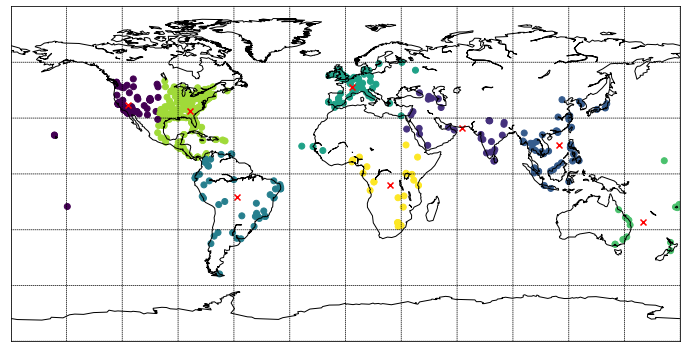

In [10]:
centers = kmeans.cluster_centers_

plot_clusters(df.KMClusters, df.Longitude, df.Latitude, gridlines=True, centers=centers)

While the various clusters of headline locations appear to generally fall within continental boundaries (or at least segments of these boundaries), there are still some clusters that:
<ul>
    <li>overlap continental boundaries (especially those in Europe, Africa and Asia)</li>
    <li>include very distant outliers (like the outliers included with western NA)</li>
    <li>built around sparcely distributed locations like SA, Africa, and the combination of India and the Middle Eastern countries</li>
</ul>
Part of the underlying cause of these issues revolves around the fact that the number of clusters is fixed ahead of time and, in turn, the number of centroids is fixed so that individual points are 'forced' into some cluster even if the distance from the cluster's centroid is substantial.

Some of these issues are addressed by DBSCAN clustering because the number of clusters isn't fixed and the clusters are derived by finding dense collections and eliminating outliers. So, theoretically the clusters generated by DBSCAN should be more reasonable.

<b>2.2. Plot of DBSCAN Clusters with eps = 10, min_samples=5, and (for the moment) metric='euclidean'.</b>

Before we actually plot the clusters produced by DBSCAN, we need to eliminate the outliers found in the process (i.e. headlines/cities with DBSCluster = -1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 586 entries, 0 to 610
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Headline     586 non-null    object 
 1   City         586 non-null    object 
 2   Country      15 non-null     object 
 3   Latitude     586 non-null    float64
 4   Longitude    586 non-null    float64
 5   CountryCode  586 non-null    object 
 6   KMClusters   586 non-null    int32  
 7   DBSClusters  586 non-null    int64  
dtypes: float64(2), int32(1), int64(1), object(4)
memory usage: 38.9+ KB


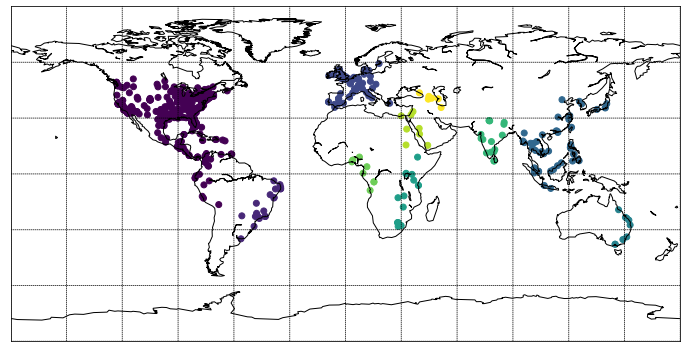

In [11]:
df_no_outliers = df[df.DBSClusters > -1]
df_no_outliers.info()

plot_clusters(df_no_outliers.DBSClusters, df_no_outliers.Longitude,
              df_no_outliers.Latitude, gridlines=True)

Ignoring Basemap's default selection of colors, DBSCAN does a better job of creating denser clusters. However, there are still seems to be issues with the large cluster in North America. Part of this maybe due to the fact that 'eps' (the cluster radius) was set at 10. It may also be due in part to the fact that the distances are 'Euclidean' (linear) distances instead of geodesic (curved) distances. The former issue is addressed next while the latter issue is addressed a bit later.    

<h3>3. In the likely case that the first clustering is not ideal, adjust the parameters of the algorithm you choose or use a different algorithm.</h3>
<ul>
    <li>You can use an elbow plot to select the number of clusters in k-means.</li>
    <li>The two most important parameters for DBSCAN are eps and min_samples</li>
</ul>


<b>3.1. Selecting the Number of Clusters (k) for KMeans</b>

As noted earlier, KMeans assigns data points to a cluster such that the <em>within-cluster sum-of-squares</em> between the data points and the cluster’s centroid (arithmetic mean) is at the minimum.
In KMeans the 'within-cluster sum-of-squares' is called 'inertia'. At the end of any clustering run, the minimum value achieved during the run is stored in the 'inertia_' attribute. 

Unlike some other performance measures, 'inertia' is unstandardized. It's magnitude depends not only on the magnitude of the numbers in the dataset, but also on the pre-specified number of clusters (k). For any given dataset, as the 'k' increases, the inertia will decrease (in a nonlinear fashion). By plotting the inertia for several values of k, we can visually determine which value is best (or at least narrow the choices). The resulting plot is called an 'elbow' plot because of its resemblance to an arm bent at the elbow.

K  Inertia
2  1,043,582
3  489,050
4  344,787
5  268,825
6  208,094
7  153,417
8  131,015
9  110,295
10  95,493
11  83,263
12  75,579
13  69,062
14  61,864
15  57,948
16  52,092
17  47,809
18  45,220
19  43,221


Text(0.5, 0, 'K')

Text(0, 0.5, 'Inertia')

(1.0, 20.0)

(0.0, 1100000.0)

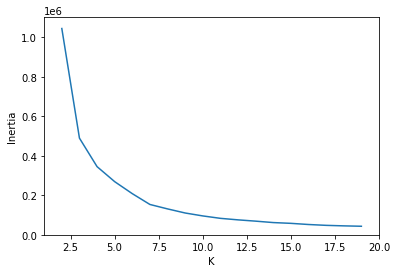

In [12]:
# Utilize elbow plot to determine number of clusters k based on inertia

inertia_values = []

print('K  Inertia')
for k in range(2,20):
    kmeans = KMeans(n_clusters=k)
    inertia  = kmeans.fit(coordinates).inertia_
    print('{0}  {1:,.0f}'.format(k, inertia))
    inertia_values.append(inertia)

plt.plot(range(2, 20), inertia_values)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.xlim(1, 20)
plt.ylim(0.0*1e6, 1.1*1e6);
plt.show()

There appear to be noticeable inflection points at k=3, 4 and 7. Yet, based on what we know from mapping the cluster when k=8 (the default), it appears that none of these inflections is really a viable alternative. If anything a more reasonable choice might be something between 10 and 17.   

<b>3.2. Selecting 'eps' and 'min_samples' for DBSCAN</b>

As noted, by default in DBSCAN the distance between any two points is computed by Euclidean distance. If the distance between two points is less than or equal to a prespecified radius 'eps', then they are in the same neighborhood. For a neighborhood to constitute a cluster, there has to be at least min_samples points within the radius. Like 'eps', 'min_samples' is also prespecified. As the sklearn DBSCAN documentation indicates, of the two 'eps' is the most important DBSCAN parameter to choose appropriately for your data set and distance function. Given this let's look a the selection of 'eps' first.

EPS Selection

While there are no hard and fast rules for selecting the value of 'eps' for a specific dataset, one method that has been cited in a variety of places revolves around the average distance among the k-nearest neighbors where k is the minimum sample size. The basic process resembles the above process for selecting the number of clusters for KMeans. However, instead of using an elbow plot of inertia values, it's a 'knee' plot of average distances.  The method works like this (see https://www.datanovia.com/en/lessons/dbscan-density-based-clustering-essentials/#method-for-determining-the-optimal-eps-value):

<ol>
    <li>The idea is to calculate, the average of the distances of every point to its k nearest neighbors. The value of k will be specified by the user and corresponds to MinPts.</li>
    <li>Next, these k-distances are plotted in an ascending order. The aim is to determine the “knee”, which corresponds to the optimal eps parameter.</li>
    <li>A knee corresponds to a threshold where a sharp change occurs along the k-distance curve</li>
</ol>

The code below implements these steps for a dataset of coordinates with min_sample = k.

In [13]:
# Plotting Avg Distance for min_samples = k

from scipy.spatial import distance

def avg_dist_kNN(coordinates, k, metric):
    coord_tuples = list(map(tuple,coordinates))
    dists = distance.cdist(coord_tuples, coord_tuples, metric)
    dists.sort(axis=1)
    dist_means = np.mean(dists[:,:k],axis=1)
    dist_means.sort(axis=0)
    return dist_means

def kNN_avg_dist_plot(kList, metric): 
    fig, ax = plt.subplots()
    for k in kList:
        dist_means = avg_dist_kNN(coordinates, k, metric)
        ax.plot(dist_means,label = 'k=' + str(k))
    ax.set_title('Selecting EPS for DBSCAN Run')
    ax.set_xlabel('Sort Order')
    ax.set_ylabel('Avg Distance')
    ax.legend()

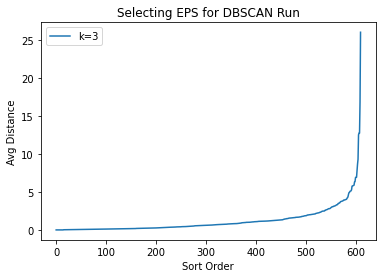

In [14]:
# kDistance plot for min_samples = 5

kNN_avg_dist_plot([3],'euclidean')

In the Basemap of DBSCAN clusters displayed (see 2.2 above), the clustering was based (somewhat arbitrarily) on an eps=10 and min_samples=5 (which is the default). Was this a reasonable combination?

The kNN_avg_dist plot shown directly above was constructed by first calculating the Euclidean distance between all pairs of the individual city coordinates (latitude-longitude) in the headline dataset. Next, for each city coordinate, an average of the k=5 shortest distances between that particular coordinate and all city coordinates (including itself) was calculated. These 611 average (mean) short distances were then sorted in descending order and plotted, yielding the kNN_avg_distance plot above.  In this plot the threshold (i.e. knee) appears to be somewhere around 7-8. So, instead setting eps=10, as was originally done, an eps=7.5 might have been better for min_samples = 5.

Of course, this leaves open the question about the best value for the number of min_samples. In the graph shown immediately below, we can see the kNN_avg_distance plots for the same dataset with varying min_sample sizes. From this, we can see that the curves for the various min_samples sizes have basically the same shape with moderately small differences in their inflection points (running from 5-10 for the 4 samples sizes.  Knowing that the default values for eps and min_samples are 0.5 and 5, respectively, it's clearly more worthwhile to use this sort of plot to select potential values for eps than for the min_samples size.   

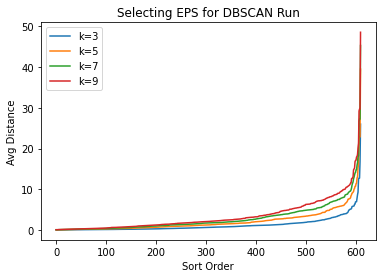

In [15]:
# kNN_avg_dist plot for a list of min_samples

kNN_avg_dist_plot([3,5,7,9],'euclidean')

<h3>4. Try using DBSCAN with the great circle distance, which finds the distance between two geographic points on a spherical globe.</h3>
<ul>
    <li>Write a function to return the Great Circle distance between two coordinate points.</li>
    <li>Use this function as the metric for DBSCAN.</li>
</ul>

<h5>4.1 Geodesic Metric: Great-Circle Distance Using Haversin Formula.</h5>

"The great-circle distance or orthodromic distance is the shortest distance between two points on the surface of a sphere, measured along the surface of the sphere (as opposed to a straight line through the sphere's interior). The distance between two points in Euclidean space is the length of a straight line between them, but on the sphere there are no straight lines. In spaces with curvature, straight lines are replaced by geodesics. Geodesics on the sphere are circles on the sphere whose centers coincide with the center of the sphere, and are called great circles".

The function below produces a metric for 'great-circle' distances. There are different formulas for doing this.  This particular version uses the 'Haversine' formula.

In [16]:
from sklearn.cluster import DBSCAN
from math import sin, asin, cos

def great_circle_distance(coord1, coord2, radius=3956):
    if np.array_equal(coord1, coord2):
        return 0.0 

    coord1, coord2 = np.radians(coord1), np.radians(coord2)
    delta_x, delta_y = coord2 - coord1
    haversin = sin(delta_x / 2) ** 2 + np.product([cos(coord1[0]),
                                                   cos(coord2[0]), 
                                                   sin(delta_y / 2) ** 2])
    return  2 * radius * asin(haversin ** 0.5)

<h5>4.2 Using DBSCAN to Cluster Cities Using Great-Circle Distances</h5>

As noted, before DBSCAN can be applied to the city coordinates in the headlines dataframe, we need to specify values for eps, min_samples, and select a distance metric. Obviously, the distance metric will be set to 'great_circle_distance' (the name of the custom function). What about the values of eps and min_samples? In the last example eps=8.  However, the distances are now being calculated in kilometers. So, we need a much larger radius. Additionally, we probably need to reduce the min_samples to ensure that there aren't too many outliers. 

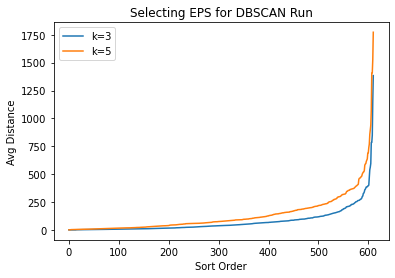

In [17]:
kNN_avg_dist_plot([3, 5],great_circle_distance)

Above are the kNN-avg_distance plots using the great_circle_distance for min_samples of 3 and 5. Looking at the curve for min_samples = 3, it appears that a reasonable value for eps when min_samples = 3 is between 200 and 300. For min_samples = 5, it around 450. For our purposes, let's start with eps=250 and min_samples=3.

In [18]:
# DBSCAN eps=250, min_samples=3, metric=great_circle_distance

# Clustering and adding cluster labels to 'df' dataframe
metric = great_circle_distance
dbscan = DBSCAN(eps=250, min_samples=3, metric=metric)
df['DBSClusters'] = dbscan.fit_predict(coordinates)

# Few statistics from DBSCAN

(unique, counts) = np.unique(df['DBSClusters'], return_counts=True)

print('\nCluster and Outlier Stats for eps=250 and min_samples = 3')
print('Number of unique clusters: {}'.format(len(unique)))
print('Range of unique clusters: {} to {}:'.format(unique[0],unique[len(unique)-1]))
print('Modal cluster: "{}" with count of {}'
          .format(unique[np.argmax(counts)],counts[np.argmax(counts)]))
print('Number of Outliers (label = -1): {}'.format(counts[0]))
print('Number of headlines with Outliers removed: {}'.format(len(df)-counts[0]))



Cluster and Outlier Stats for eps=250 and min_samples = 3
Number of unique clusters: 37
Range of unique clusters: -1 to 35:
Modal cluster: "0" with count of 240
Number of Outliers (label = -1): 84
Number of headlines with Outliers removed: 527


With this set of parameters (eps=250, min_samples=3, metric=great_circle_distance), DBSCAN clustering has yielded 37 unique clusters. One of these is the cluster labeled -1, which is the outliers of which there are 84 locations). When the outliers are removed, this leaves 36 clusters. These 36 clusters are plotted below.

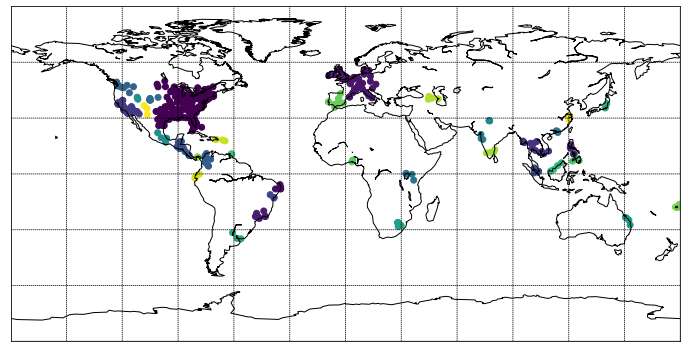

In [19]:
df_no_outliers = df[df.DBSClusters > -1]
plot_clusters(df_no_outliers.DBSClusters, df_no_outliers.Longitude,
              df_no_outliers.Latitude, gridlines=True)

While DBSCAN has done a reasonably good job of generating discrete clusters in less dense regions (South America, Asia and Africa), it appears to have had trouble distinguishing among the locations in very dense regions (like the Eastern US and Europe). Although not shown here, this holds true for number of different combinations of eps and min_samples (unless eps is so small and min_samples so large that each location becomes its own cluster).

<h3>5. Repeat the above steps—cluster, visualize, analyze, tune—as many times as is required until the algorithm correctly assigns close points to the same cluster without too many outliers.</h3>

The analysis that follows examines the shifts in the number of clusters, number of locations in modal cluster, and number of non-outlier locations.

In [20]:
# DBSCAN Cluster Analyses using 'Great Circle Distance'

def generate_dbscan_clusters(coordinates,eps,min_samples,metric):
    metric = great_circle_distance
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
    return dbscan.fit_predict(coordinates)

def dbscan_cluster_stats(df_clusters, eps, min_samples, metric):
    (unique, counts) = np.unique(df_clusters, return_counts=True)
    n_unique_clusters = len(unique)
    modal_cluster = (unique[np.argmax(counts)],counts[np.argmax(counts)])
    n_outliers = counts[0]
    n_headlines_no_outliers = len(df_clusters) - n_outliers
    return [eps,min_samples,n_unique_clusters, modal_cluster[0], modal_cluster[1], n_outliers, n_headlines_no_outliers] 

In [21]:
# refining DBSCAN - comparing number of clusters, modal cluster size, and number of outliers

# initializing key metrics
metric = great_circle_distance
eps_list = [200,250,300,350,400]
min_samples_list = [3,5]

stat_cols = ['EPS','MinSamples','NumClusts','Mode','NumMode','NumOutliers','NumNotOutliers']
cl_stats_list = []

# calculating cluster stats for various combinations of eps and min_samples
for min_samples in min_samples_list:
    for eps in eps_list:
        df_clusters = generate_dbscan_clusters(coordinates,eps,min_samples,metric)
        cluster_stats = dbscan_cluster_stats(df_clusters, eps, min_samples, metric)
        cl_stats_list.append(cluster_stats)

# dataframe of specified cluster states        
df_cluster_stats = pd.DataFrame(cl_stats_list, columns = stat_cols)

print("Cluster Statistics from DBSCAN Clustering")
df_cluster_stats

Cluster Statistics from DBSCAN Clustering


,EPS,MinSamples,NumClusts,Mode,NumMode,NumOutliers,NumNotOutliers
0,200,3,33,0,236,116,495
1,250,3,37,0,240,84,527
2,300,3,29,0,329,64,547
3,350,3,28,0,356,47,564
4,400,3,29,0,357,40,571
5,200,5,15,0,236,187,424
6,250,5,16,0,240,164,447
7,300,5,14,0,256,132,479
8,350,5,12,0,354,113,498
9,400,5,14,0,356,95,516


With the exception of the label of the modal cluster, the remaining variables are plotted below by eps and min_samples.

In [22]:
def eps_line_plots(k_list,stat_list,df_cluster_stats):
    for stat in stat_list:
        fig, ax = plt.subplots()
        for k in k_list:
            dfplot = df_cluster_stats[df_cluster_stats.MinSamples == k]
            x = dfplot.EPS
            y = dfplot[stat]
            ax.plot(x, y, label = 'k=' + str(k))
        ax.set_title(stat + ' by EPS')
        ax.set_xlabel('EPS')
        ax.set_ylabel(stat)
        ax.legend()

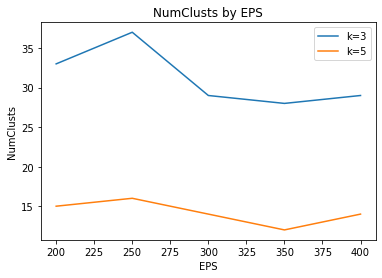

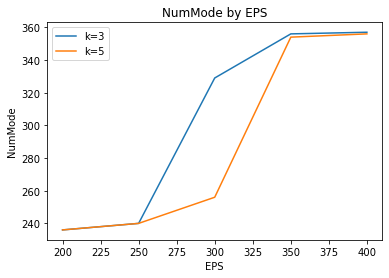

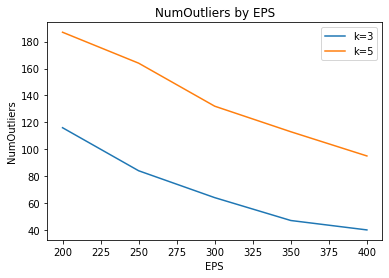

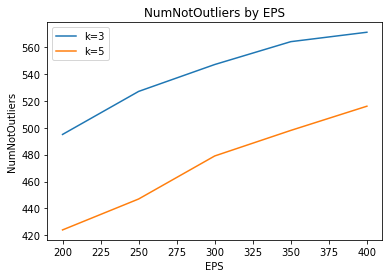

In [23]:
#stat_list = ['NumClusts','Mode','NumMode','NumOutliers','NumNotOutliers']
k_list = [3,5]
stat_list = ['NumClusts','NumMode','NumOutliers', 'NumNotOutliers']
eps_line_plots(k_list, stat_list, df_cluster_stats)

Basically, we're looking for a configuration of eps and min_samples that produces a relatively large number of clusters, with fewer locations in the modal cluster, few outliers, and consequently a larger number of non-outliers (implying that more locations to analyze). From the detailed numbers and the plots above, it is clear that there is no one correct answer, although it is obvious that min_samples should probably be 3 (rather than 5). Within this subset of rows with min_samples = 3, the eps should be between 250 and 350. Look at the values for 300 versus 350. They're relatively the same. So, let's see what happens when we map the locations for eps=300 and min_samples is 3.

DBSCAN(algorithm='auto', eps=300, leaf_size=30,
       metric=<function great_circle_distance at 0x000001FCECAD1158>,
       metric_params=None, min_samples=3, n_jobs=None, p=None)

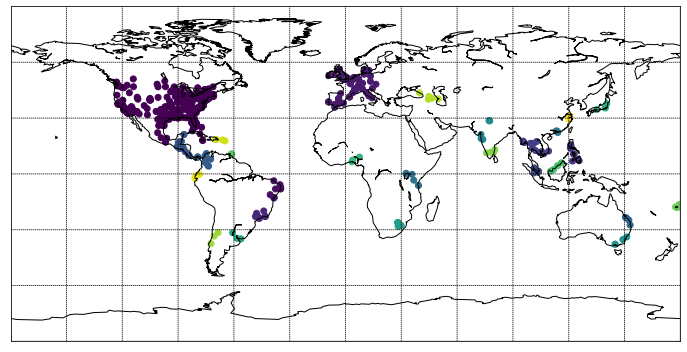

In [24]:
metric = great_circle_distance
dbscan = DBSCAN(eps=300, min_samples=3, metric=metric)
df['DBSClusters'] = dbscan.fit_predict(coordinates)
dbscan

df_no_outliers = df[df.DBSClusters > -1]
plot_clusters(df_no_outliers.DBSClusters, df_no_outliers.Longitude,
              df_no_outliers.Latitude, gridlines=True)

In this plot there are 28 clusters, excluding the cluster holding the outliers.  When eps=250, the number was 36. This is a result of the increased (eps) radius. As eps increases, the number of locations in a cluster increases. In this case the overall impact is that the number of clusters in the US and Mexico have gone from 6 clusters to 1. Similarly, the number of clusters in Europe has gone from 2 to one. This exacerbates the problem by making it even harder to distinguish among the locations in very dense regions.

The only way to attack this is to perform a separate analysis on these denser areas or to incorporate information about the different diseases into the analysis.

These approaches are left for a future time period.